In [ ]:
# Import Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve


In [ ]:

df_train = pd.read_csv('aps_failure_training_set.csv',skiprows=20)
df_test = pd.read_csv('aps_failure_test_set.csv',skiprows=20)
df_train.head(2)
print("train:",df_train.shape)
print("test:",df_test.shape)

train: (60000, 171)
test: (16000, 171)


C:\Users\SofiaHaniza\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


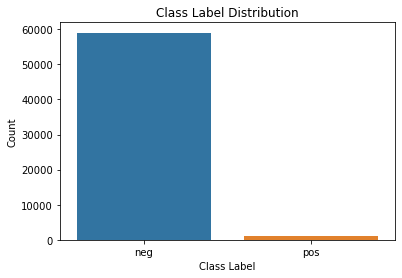

The number of positive class points is:  1000
The number of negative class points is:  59000


In [ ]:
# Plotting the distribution of class label
sns.barplot(df_train['class'].unique(),df_train['class'].value_counts())
plt.title('Class Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

print('The number of positive class points is: ',df_train['class'].value_counts()[1])
print('The number of negative class points is: ',df_train['class'].value_counts()[0])

In [ ]:
# encode to binary class
df_train['class'] = df_train['class'].replace(['pos','neg'],[1,0])
df_test['class'] = df_test['class'].replace(['pos','neg'],[1,0])

# Replace 'na' with NaN
df_train = df_train.replace('na',np.NaN)
df_test = df_test.replace('na',np.NaN)

In [ ]:
# remove feature where Std = 0, which refers to as constant value as it brings no value to the preditive model
df_train = df_train.astype(float)
for i in df_train:
  if df_train[i].std() == 0:
    df_train = df_train.drop([i],axis=1)
    print('The feature with zero variance is : ',i)
print("new_train:",df_train.shape)

df_test = df_test.astype(float)
for i in df_test:
  if df_test[i].std() == 0:
    df_test = df_test.drop([i],axis=1)
    print('The feature with zero variance is : ',i)
print("new_test:",df_test.shape)


The feature with zero variance is :  cd_000
new_train: (60000, 170)
The feature with zero variance is :  cd_000
new_test: (16000, 170)


In [ ]:
# Remove duplicate rows
df_train = df_train.drop_duplicates(keep = 'first')
df_train = df_train.T.drop_duplicates().T
print(df_train.shape)

df_test = df_test.drop_duplicates(keep = 'first')
df_test = df_test.T.drop_duplicates().T
print(df_test.shape)

(59999, 170)
(16000, 170)


C:\Users\SOFIAH~1\AppData\Local\Temp/ipykernel_14932/3497367396.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(map('{:.1f}%'.format, plot.yaxis.get_majorticklocs()))


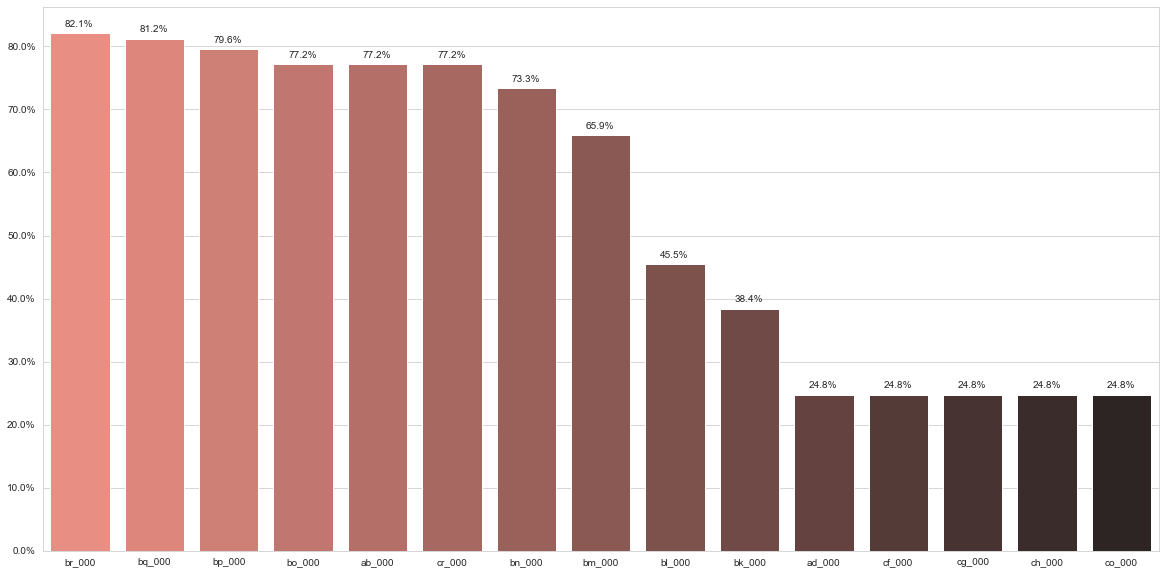

In [ ]:
x=df_train
# Creating a dictionary whose keys are the column names and values are the percentage of missing values
nan_count = {k:list(x.isna().sum()*100/x.shape[0])[i] for i,k in enumerate(x.columns)}

# Sorting the dictionary in descending order based on the percentage of missing values
nan_count = {k: v for k, v in sorted(nan_count.items(), key=lambda item: item[1],reverse=True)}
# Plotting a graph showing the top 15 features having highest percentage of missing values 
sns.set_style(style="whitegrid")
plt.figure(figsize=(20,10))

# Bar Plot
plot = sns.barplot(x= list(nan_count.keys())[:15],y = list(nan_count.values())[:15],palette="dark:salmon_r")

# Add annotations above each bar signifying their value
for p in plot.patches:
        plot.annotate('{:.1f}%'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+1))

# Make y-axis more interpretable
plot.set_yticklabels(map('{:.1f}%'.format, plot.yaxis.get_majorticklocs())) 
plt.show()

In [ ]:
# Check for missing value
mis_val = pd.DataFrame(df_train.isnull().sum()).reset_index().rename(columns = {'index':'Features', 0: 'Null_val'})
mis_val['Missing_Percentage'] = (mis_val['Null_val']/len(df_train))*100
mis_val = mis_val.sort_values('Missing_Percentage', ascending = False).reset_index().head()
mis_val.head()
# drop Features where missing value more than 60% (more than half)
removed = list(mis_val.loc[mis_val['Missing_Percentage'] > 60, 'Features'])
df_train.drop(columns = removed, inplace = True)

print('new_train_dimension:',df_train.shape)

mis_val1 = pd.DataFrame(df_test.isnull().sum()).reset_index().rename(columns = {'index':'Features', 0: 'Null_val'})
mis_val1['Missing_Percentage'] = (mis_val1['Null_val']/len(df_test))*100
mis_val1 = mis_val1.sort_values('Missing_Percentage', ascending = False).reset_index().head()
mis_val1.head()
# drop Features where missing value more than 60% (more than half)
removed = list(mis_val1.loc[mis_val1['Missing_Percentage'] > 60, 'Features'])
df_test.drop(columns = removed, inplace = True)

print('new_test_dimension:',df_test.shape)

new_train_dimension: (59999, 165)
new_test_dimension: (16000, 165)


In [ ]:
# Imputing missing values
# Replace 'na' with NaN
df_train = df_train.replace('na',np.NaN)
df_test = df_test.replace('na',np.NaN)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')
imputer.fit(df_train)
df_train = pd.DataFrame(imputer.transform(df_train), columns=df_train.columns)
df_test = pd.DataFrame(imputer.transform(df_test), columns=df_test.columns)


In [ ]:
train_labels = df_train['class']
test_labels = df_test['class']
train_features = df_train.drop('class', axis=1)
test_features = df_test.drop('class', axis=1)

In [ ]:
#Oversampling of minority class
from imblearn.over_sampling import SMOTE
from imblearn import over_sampling

# transform the dataset
oversample = over_sampling.SMOTE()
train_features, train_labels = oversample.fit_resample(train_features, train_labels)

In [ ]:
# summarize the new class distribution
from collections import Counter
counter = Counter(train_labels)
print(counter)

Counter({0.0: 58999, 1.0: 58999})


In [ ]:
# build model
# Classification using Gradient Boosting Methods

gbc = GradientBoostingClassifier(random_state=0)
params = [{'loss':['deviance','exponential'],'n_estimators':range(50,71,10),
          'min_samples_leaf':[5,10,50]}]
gbcc = GridSearchCV(gbc, params, cv=5, scoring='recall', verbose=10, n_jobs=3)
gbcc.fit(train_features, train_labels)
gbc=gbcc
display(gbc)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [ ]:
y_pred = gbc.predict(test_features)
report = classification_report(test_labels,y_pred)
print(report)

cm = confusion_matrix(test_labesl, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn','fp','fn','tp'])
total_cost = 10*cm.fp + 500*cm.fn
print(f'Total_cost is: {float(total_cost.values[0])}')

In [ ]:
# Classification for RandomForest Classifier
params = [{'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2'], 'n_estimators': range(100,201,25),
           'max_depth': [10,20,30]}]
rfc = RandomForestClassifier(random_state=0)
#Executa grid search com cross validation
rfcc = GridSearchCV(rfc, params, cv=5, scoring='recall', verbose=10, n_jobs=3)
rfcc.fit(best_train_features_balanced, train_labels_balanced)
rfc = rfcc

In [ ]:
#Evaluating the Random Forest Model
y_pred = rfc.predict(best_test_features)
report = classification_report(test_labels, y_pred)
print(report)
cm = confusion_matrix(test_labels, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
total_cost = 10*cm.fp + 500*cm.fn
print(f'Total cost is: {float(total_cost.values[0])}')

In [ ]:
#Classification using XGBoost
from xgboost import XGBClassifier
params = [{'max_depth': [3,4,5], 'n_estimators': [50,100,150], 'learning_rate': [ 0.01,0.05,0.1]}]
xgb = GridSearchCV(XGBClassifier(), params, cv=5, scoring='recall', verbose=10, n_jobs=3)
xgb.fit(best_train_features_balanced, train_labels_balanced)

In [ ]:
#Evaluating 
y_pred = xgb.predict(best_test_features)
report = classification_report(test_labels, y_pred)
print(report)
cm = confusion_matrix(test_labels, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
total_cost = 10*cm.fp + 500*cm.fn
print(f'Total cost is: {float(total_cost.values[0])}')

source:
https://github.com/VidyutRao/APS-Failure-In-Scania-Trucks/blob/master/APS%20Failure%20in%20Scania%20Trucks.ipynb